---
blogpost: true
date: Oct 01, 2034
location: Lösung
category: Übung
tags: Abtastung, Rechteck, Aliasing
---

# Abtastung eines Rechtecksignals in der Radartechnik

GPS (Global Positioning System) ist ein satellitengestütztes Navigationssystem, das genaue Standort- und Zeitinformationen liefert. GPS basiert auf Satelliten, die mit codierten **Radiosignalen** ständig ihre aktuelle Position und die genaue Uhrzeit ausstrahlen. Aus den Signallaufzeiten können spezielle Empfänger ihre eigene Position und Geschwindigkeit berechnen. Theoretisch reichen die Signale von drei Satelliten aus, welche sich oberhalb ihres Abschaltwinkels befinden müssen, um daraus die genaue Position und Höhe zu bestimmen. Das GPS-Signal hat eine Wellenlänge von $19\,\mathrm{cm}$, was einer Frequenz von $1,57542\,\mathrm{GHz}$ entspricht. Aufgrund der hohen Frequenz und der zahlreichen Oberwellen ist es entscheidend, die Signale korrekt abzutasten, um Aliasing zu vermeiden und präzise Positionsdaten zu erhalten.
Ein Rechtecksignal (hier stellvertetend für den PRN code) mit einer Grundfrequenz von $10\,\mathrm{MHz}$ wird mit einer Abtastrate von $200\,\mathrm{MHz}$ digitalisiert.

1. **Überprüfung des Abtasttheorems:**

   * Geben Sie an, ob in diesem Fall das Abtasttheorem nach Shannon erfüllt ist!
   * Begründen Sie Ihre Antwort!

Die Grundfrequenz der Rechteckschwingung wird aus der Periodendauer berechnet $ f = \frac{1}{T} $. Das Rechtecksignal kann mittels Fourierreihe in mehrere Oberschwingungen (Harmonische) zerlegt werden, weshalb nicht nur die Grundfrequenz bei der Abtastung berücksichtigt werden muss, sondern auch die Oberschwingungen. Die Fourier-Reihe einer Rechteckschwingung, die nur ungeradzahlige Harmonische enthält, kann wie folgt dargestellt werden (siehe Vorlesungsskript):

$$
x(t) = \sum_{k=0}^{\infty} \left( \frac{4}{\pi (2k+1)} \right) \sin\left( 2 \pi (2k+1) f_0 t \right)
$$

Dabei ist:
- $ x(t) $ die Amplitude des Rechtecksignals zu einem Zeitpunkt $ t $.
- $ f_0 $ die Grundfrequenz des Rechtecksignals.
- $ k $ ein Index, der von 0 bis unendlich läuft und sicherstellt, dass nur **ungeradzahlige Harmonische** in die Summe eingehen.
- $ (2k+1) $ sorgt dafür, dass nur die ungeradzahligen Vielfachen der Grundfrequenz berücksichtigt werden.

In den nachfolgenden Diagrammen ist gezeigt, inwiefern ein Rechtecksignal verzerrt wird, wenn relevante Oberschwingungen vernachlässigt werden:

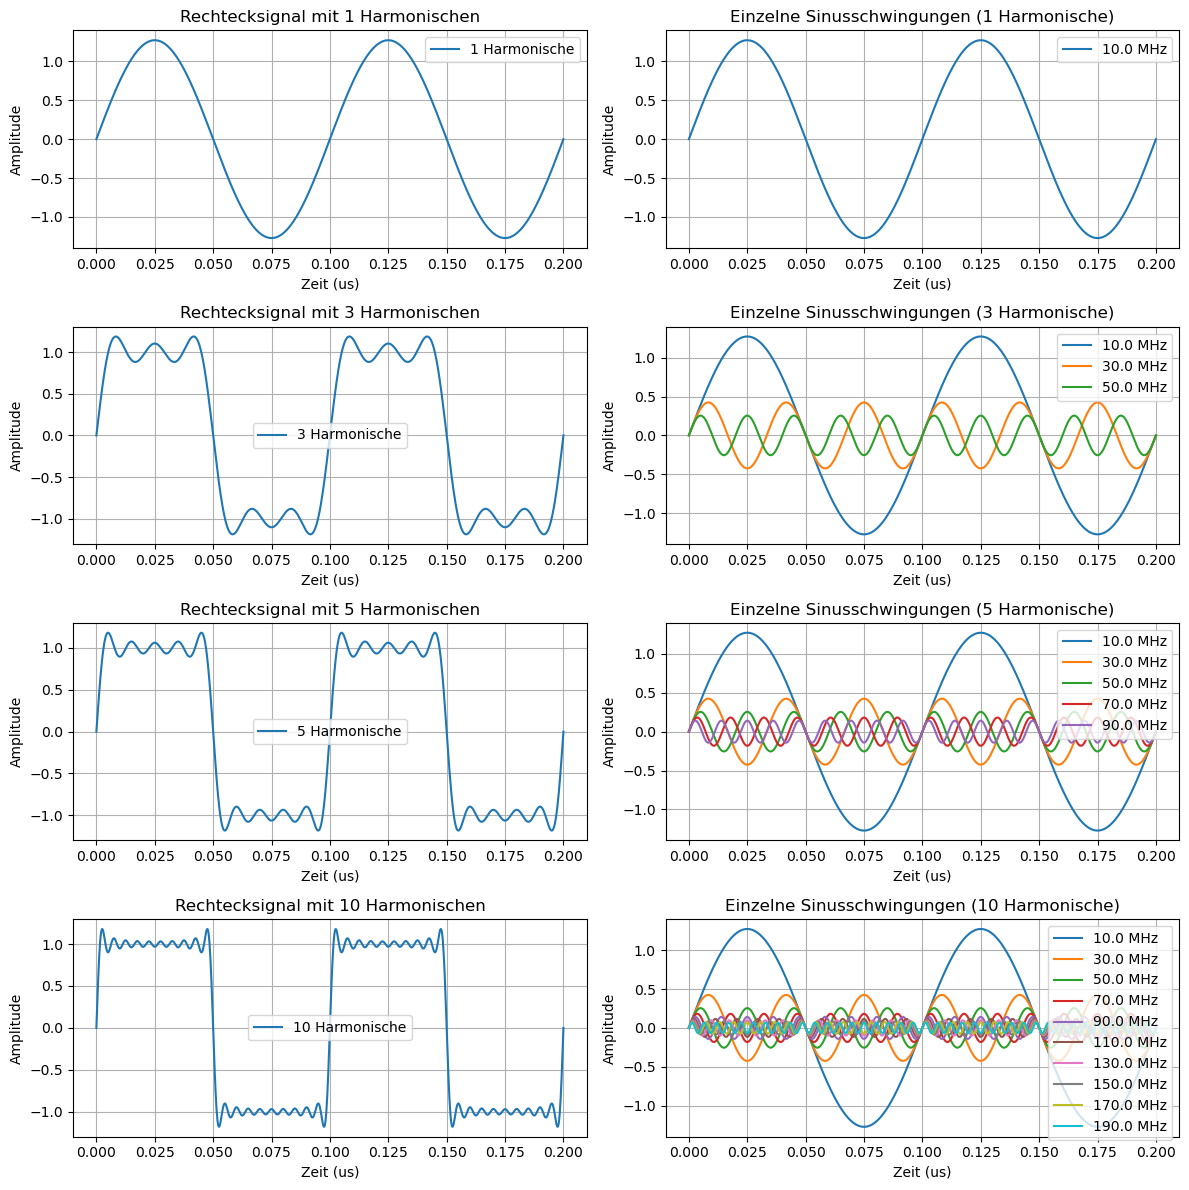

Grundfrequenz: 10.0 MHz
Nyquist-Frequenz: 100.0 MHz
Harmonische: [30. 50. 70.] MHz
Erfüllt das Abtasttheorem? Ja


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

# Parameter für das Rechtecksignal
f0 = 10e6 # Grundfrequenz in Hz 
fs = 200e6  # Abtastrate in Hz (Beispiel: 5 kHz)
nyquist_freq = fs/2  # Beispielwert für Nyquist-Frequenz (Hälfte der Abtastrate)
T = 1 / f0  # Periodendauer in Sekunden
t = np.linspace(0, 2 * T, 1000)  # Zeitvektor für zwei Perioden


# Funktion zur Berechnung des Rechtecksignals mit n Harmonischen
def square_wave(t, f0, n_harmonics):
    signal = np.zeros_like(t)
    harmonics_signals = []
    frequencies = []
    for n in range(1, 2 * n_harmonics, 2):  # Nur ungeradzahlige Harmonische
        harmonic_signal = (4 / (np.pi * n)) * np.sin(2 * np.pi * n * f0 * t)
        harmonics_signals.append(harmonic_signal)
        frequencies.append(n * f0)
        signal += harmonic_signal
    return signal, harmonics_signals, frequencies

# Plotten des Rechtecksignals mit unterschiedlichen Anzahlen von Harmonischen
plt.figure(figsize=(12, 12))

n_harmonics_list = [1, 3, 5, 10]  # Anzahlen von Harmonischen

for i, n_harmonics in enumerate(n_harmonics_list):
    signal, harmonics_signals, frequencies = square_wave(t, f0, n_harmonics)
    
    # Plotten des zusammengesetzten Rechtecksignals
    plt.subplot(len(n_harmonics_list), 2, 2*i + 1)
    plt.plot(t*1000000, signal, label=f'{n_harmonics} Harmonische')
    plt.title(f'Rechtecksignal mit {n_harmonics} Harmonischen')
    plt.xlabel('Zeit (us)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    
    # Plotten der einzelnen Sinusschwingungen
    plt.subplot(len(n_harmonics_list), 2, 2*i + 2)
    for harmonic_signal, freq in zip(harmonics_signals, frequencies):
        plt.plot(t*1000000, harmonic_signal, label=f'{freq/1000000:.1f} MHz')
    plt.title(f'Einzelne Sinusschwingungen ({n_harmonics} Harmonische)')
    plt.xlabel('Zeit (us)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Überprüfung des Abtasttheorems
harmonics = np.array([3, 5, 7]) * f0  # ungeradzahlige Harmonische
is_nyquist_met = np.all(harmonics <= nyquist_freq)

print(f"Grundfrequenz: {f0*1e-6} MHz")
print(f"Nyquist-Frequenz: {nyquist_freq*1e-6} MHz")
print(f"Harmonische: {harmonics*1e-6} MHz")
print(f"Erfüllt das Abtasttheorem? {'Ja' if is_nyquist_met else 'Nein'}")

Das Abtasttheorem ist in diesem Falle nicht erfüllt, da eine Nyquist-Frequenz von $\frac{f_s}{2} = 100\,\mathrm{MHz}$ bereits die relevante Oberschwingungen nicht mehr korrekt abtasten kann und somit das Abtasttheorem verletzt. 

2. **Effekte bei Verletzung des Abtasttheorems:**

   * Welcher Effekt tritt ein, wenn das Abtasttheorem verletzt ist?
   * Erläutern Sie diesen Effekt mit einer einfachen Skizze.
   
Wenn das Abtasttheorem verletzt wird, tritt Aliasing auf. Aliasing bedeutet, dass höhere Frequenzen im Signal als niedrigere Frequenzen erscheinen, was zu einer falschen Darstellung des Originalsignals führt.

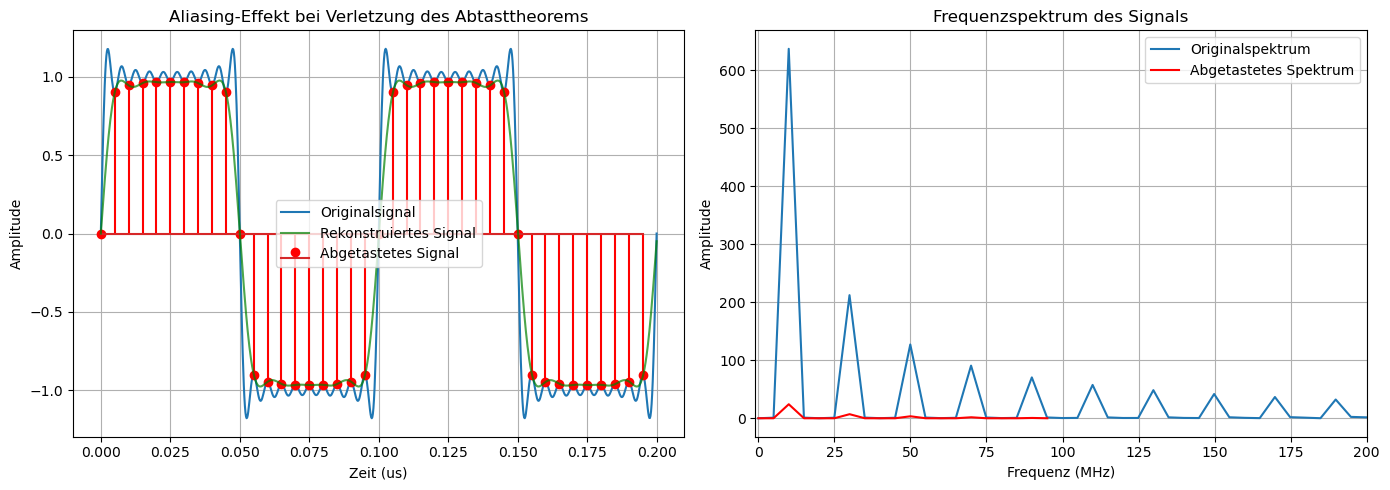

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

# Parameter für das Rechtecksignal
t = np.linspace(0, 2 * T, 1000)  # Zeitvektor für zwei Perioden
t_sampled = np.arange(0, 2 * T, 1 / fs)  # Abgetastete Zeitvektor

# Funktion zur Berechnung des Rechtecksignals mit n Harmonischen
def square_wave(t, f0, n_harmonics):
    signal = np.zeros_like(t)
    for n in range(1, 2 * n_harmonics, 2):  # Nur ungeradzahlige Harmonische
        harmonic_signal = (4 / (np.pi * n)) * np.sin(2 * np.pi * n * f0 * t)
        signal += harmonic_signal
    return signal

# Berechnung des Rechtecksignals mit mehreren Harmonischen
n_harmonics = 10  # Anzahl der Harmonischen
signal = square_wave(t, f0, n_harmonics)
sampled_signal = square_wave(t_sampled, f0, n_harmonics)

# Rekonstruktion des Signals aus den abgetasteten Werten
reconstructed_signal = resample(sampled_signal, len(t))

# Berechnung der Fourier-Transformation des Original- und des Abgetasteten Signals
frequencies = np.fft.fftfreq(len(t), t[1] - t[0])
original_spectrum = np.fft.fft(signal)
sampled_frequencies = np.fft.fftfreq(len(t_sampled), t_sampled[1] - t_sampled[0])
sampled_spectrum = np.fft.fft(sampled_signal)

# Plotten des Aliasing-Effekts
plt.figure(figsize=(14, 5))

# Zeitbereich
plt.subplot(1, 2, 1)
plt.plot(t*1000000, signal, label='Originalsignal')
plt.stem(t_sampled*1000000, sampled_signal, 'r', markerfmt='ro', label='Abgetastetes Signal')
plt.plot(t*1000000, reconstructed_signal, 'g', label='Rekonstruiertes Signal', alpha=0.7)
plt.xlabel('Zeit (us)')
plt.ylabel('Amplitude')
plt.title('Aliasing-Effekt bei Verletzung des Abtasttheorems')
plt.legend()
plt.grid(True)

# Frequenzbereich des Abgetasteten Signals
plt.subplot(1, 2, 2)
plt.plot(frequencies[:len(frequencies)//2]/1000000, np.abs(original_spectrum)[:len(frequencies)//2], label='Originalspektrum')
plt.plot(sampled_frequencies[:len(sampled_frequencies)//2]/1000000, np.abs(sampled_spectrum)[:len(sampled_frequencies)//2], 'r', label='Abgetastetes Spektrum')
plt.xlabel('Frequenz (MHz)')
plt.xlim([-1, 200])
plt.ylabel('Amplitude')
plt.title('Frequenzspektrum des Signals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


3. **Praktische Anwendung:**

   * Erklären Sie, warum es in der Radartechnik wichtig ist, die Abtastfrequenz korrekt zu wählen und welche Konsequenzen eine Verletzung des Abtasttheorems haben könnte.
   
GPS-Systeme nutzen hochfrequente Signale, die sowohl fundamentale als auch harmonische Komponenten enthalten. Diese Signale müssen korrekt abgetastet werden, um präzise Positionsbestimmungen zu ermöglichen. Aliasing tritt auf, wenn die Abtastrate nicht ausreicht, um die höchsten Frequenzkomponenten des Signals korrekt zu erfassen, was zu verschiedenen Fehlern führt.

**Hochfrequentes Rauschen und Signalintegrität**:
GPS-Signale werden bei hohen Frequenzen übertragen und enthalten sowohl Grund- als auch Oberwellen. Hochfrequentes Rauschen kann diese Signale stören. Wenn die Abtastrate nicht ausreicht, um diese hohen Frequenzkomponenten korrekt zu erfassen, tritt Aliasing auf. Dies führt dazu, dass diese Frequenzen in den niedrigeren Frequenzbereich "gefaltet" werden, was die Interpretation des tatsächlichen Signals verfälscht und die genaue Zeitmessung beeinträchtigt, die für eine präzise GPS-Positionsbestimmung erforderlich ist.

**Präzise Zeit- und Positionsbestimmung**:
GPS-Systeme verlassen sich auf präzise Zeitmessungen, um die Entfernungen zwischen Satelliten und dem Empfänger zu berechnen. Die Position wird anhand der Laufzeiten der Signale von mehreren Satelliten zum Empfänger trianguliert. Aliasing verfälscht die Phaseninformationen des Signals, was die Genauigkeit der Zeitmessungen beeinträchtigt. Jede Ungenauigkeit bei der Zeitmessung führt zu Fehlern bei der Positionsbestimmung.

**Pseudo-Zufällige Code-Sequenzen**:
GPS-Signale verwenden pseudo-zufällige Rauschcodes (PRN), um das Signalspektrum zu erweitern. Diese Codes müssen korrekt abgetastet werden, um die Informationen genau zu dekodieren. Aliasing kann die richtige Dekodierung dieser PRN-Codes stören, was zu Fehlern bei der Identifizierung des Ursprungs des Satellitensignals und seiner genauen Zeit führt.

**Multipath-Effekte**:
Aliasing kann die Auswirkungen von Multipath-Propagation verschlimmern, bei der Signale von Oberflächen reflektiert werden, bevor sie den Empfänger erreichen. Dies führt zu mehreren überlappenden Kopien des Signals. Eine korrekte Abtastung ist erforderlich, um zwischen direkten und reflektierten Signalen zu unterscheiden. Aliasing kann diese Signale stärker stören, was die Filterung der reflektierten Signale erschwert und zu Positionsfehlern führt.

**Spektrales Leckage**:
Beim GPS-Signalverarbeitung kann spektrales Leckage durch Aliasing dazu führen, dass die Energie von Hochfrequenzkomponenten in benachbarte Frequenzen überläuft. Dieses Leckage stört die Erkennung und Isolierung der tatsächlichen Signalbestandteile, verschlechtert das Signal-Rausch-Verhältnis (SNR) und erschwert die genaue Signalinterpretation.

**Zusammenfassung**:
Aliasing führt zu erheblichen Fehlern in GPS-Systemen, indem es Hochfrequenzkomponenten verzerrt, präzise Zeitmessungen stört, die Dekodierung pseudo-zufälliger Codes beeinträchtigt, Multipath-Effekte verstärkt und spektrales Leckage verursacht. Um diese Fehler zu minimieren, müssen GPS-Systeme eine ausreichend hohe Abtastrate verwenden, die das Nyquist-Kriterium erfüllt und die höchsten Frequenzkomponenten des Signals korrekt erfasst.

https://meetings.copernicus.org/www.cosis.net/abstracts/EGU06/07817/EGU06-J-07817.pdf
